In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd


#Get all neighborhoods in an array and add it to the neighborhood_metrics
neighborhood_shapes = gpd.read_file("Neighborhoods_.geojson")

# When you add your metric column, make sure it's aligned to the way the neighborhoods are stored in neighborhood_metrics

# Asbestos

In [2]:
asbestos_data = pd.read_csv("data_with_neighborhoods/Asbestos_WithNeighborhood.csv")

reads data from data_with_neighborhoods/Asbestos_WithNeighborhood.csv

In [3]:
asbestos_query = asbestos_data["job_complete"] == "f"
contains_asbestos = asbestos_data[asbestos_query]

creates another data set that only incorporates buildings in which asbestos is untreated

**The 5 neighborhoods with the most buildings with asbestos:**

In [4]:
pd.DataFrame(contains_asbestos["neighborhood"].value_counts().head(5))

,neighborhood
Central Business District,186
West Oakland,66
Squirrel Hill North,35
Allegheny Center,32
North Oakland,31


**The 5 nieghborhoods with the least amount of asbestos:**

In [5]:
pd.DataFrame(contains_asbestos["neighborhood"].value_counts().tail(5))

,neighborhood
Beltzhoover,1
Spring Hill-City View,1
Polish Hill,1
Terrace Village,1
East Carnegie,1


**Bar graph of all asbestos quanities per neighborhood:**

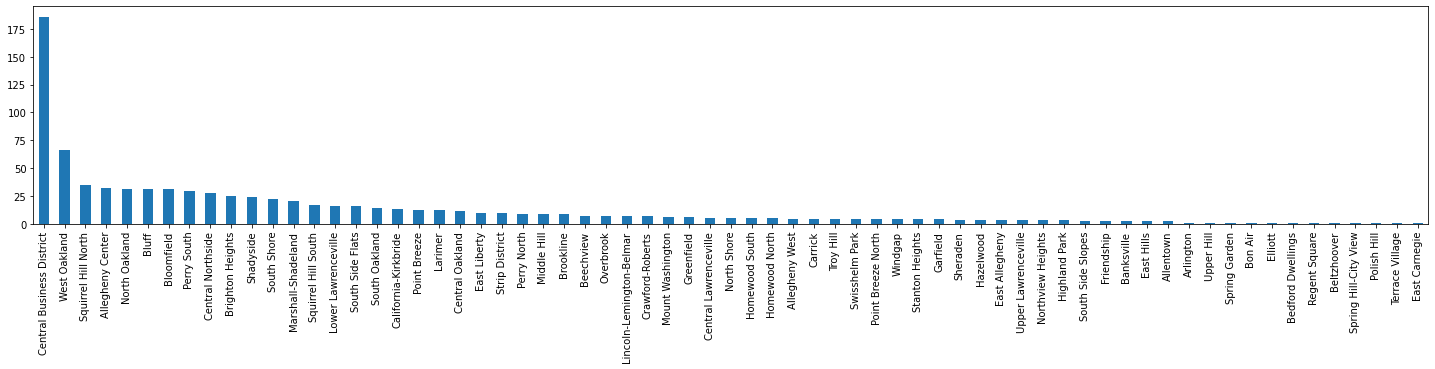

In [6]:
contains_asbestos["neighborhood"].value_counts().plot.bar(figsize = (25,4))

**Scoring for Asbestos:**

Based off of the percentage of untreated asbestos to total buildings checked for asbestos

This prevents the data from being too skewed, since if a neighborhood had more buildings checked, then it would clearly have a higher amount of asbestos found

Any null value is replaced with a 0, since that neighborhood had no asbestos found

In [7]:
scores = contains_asbestos["neighborhood"].value_counts().sort_index()/asbestos_data["neighborhood"].value_counts().sort_index()*100
scores = scores.fillna(0)
scores = scores.round()
scores = scores.sort_values(0,False)

The scores are then stored into a DataFrame to create a map for the data

In [9]:
df_scores = pd.DataFrame(scores)
df_scores = df_scores.reset_index()
df_scores.columns = ["neighborhood","score"]
df_scores

,neighborhood,score
0,Regent Square,100.0
1,Arlington,100.0
2,Polish Hill,100.0
3,Windgap,67.0
4,North Shore,62.0
...,...,...
80,Chateau,0.0
81,Crafton Heights,0.0
82,Hays,0.0
83,Duquesne Heights,0.0


**Map of Asbestos Scores:**

Finally, merging the scores DataFrame with the Map DataFrame and creating the Score's Map

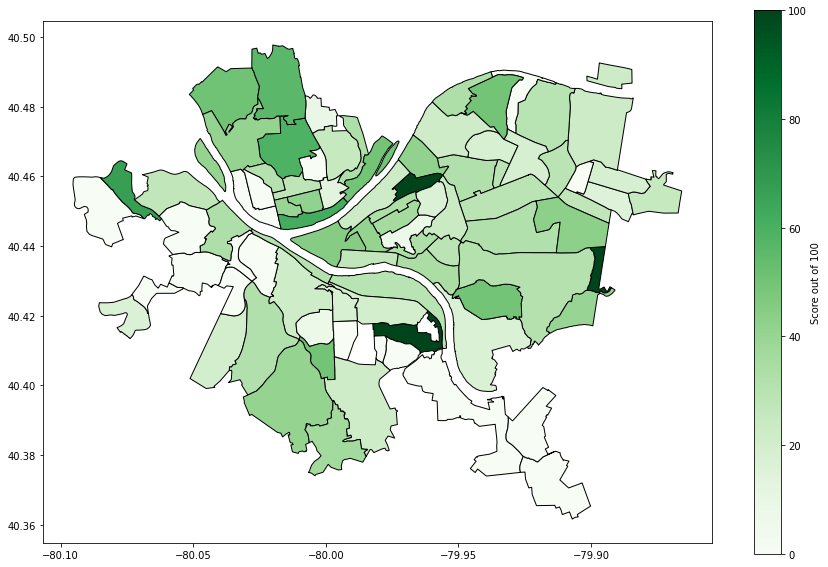

In [11]:
scores_map = neighborhood_shapes.merge(df_scores, how = 'left', left_on = 'hood', right_on = 'neighborhood')
scores_map.plot(column = 'score', figsize = (15,10), cmap = 'Greens', edgecolor = 'black', legend = True, legend_kwds={'label': "Score out of 100"})

# Restaurant Inspections

The second dataset analyzed describes the results of restaurant health inspections on buildings throughout allegheny county. This relates to the expected level of health you could expect to have living in an area, because a neighborhood with poorly maintained restaurants would be less safe to eat in.

In [12]:
# Load data
restaurantInspections = pd.read_csv("data_with_neighborhoods/restaurantInspections_WithNeighborhood.csv", low_memory = False)

# Use a mask to extract the rows from the data where a building fails an inspection
restaurant_fail_mask = restaurantInspections["placard_desc"]!="Inspected & Permitted"
restaurant_fail = restaurantInspections[restaurant_fail_mask]

In [13]:
# Groupby neighborhood and count the number of instances per neighborhood
# Because the only data in restaurant_fail is failed results, this count is the number of failed inspections
restaurant_fail_count = restaurantInspections.groupby("neighborhood")["placard_desc"].apply(lambda x: (x!="Inspected & Permitted").sum())

#restaurant_fail.groupby("neighborhood")["placard_desc"].count()

# Generate total count in a similar way
restaurant_total_count = restaurantInspections.groupby("neighborhood")["placard_desc"].count()

# Print data to console

restaurant_properties = pd.DataFrame({
    "failures": restaurant_fail_count,
    "total": restaurant_total_count,
})

restaurant_properties["percentage"] = restaurant_properties.apply(lambda row: row["failures"]/row["total"]*100, axis = 1)

print(restaurant_properties)

                     failures  total  percentage
neighborhood                                    
Allegheny Center            7    246    2.845528
Allegheny West              2    164    1.219512
Allentown                   0     48    0.000000
Arlington                   0     47    0.000000
Arlington Heights           0      5    0.000000
...                       ...    ...         ...
Upper Lawrenceville        11    334    3.293413
West End                    3    415    0.722892
West Oakland                0    101    0.000000
Westwood                    1    178    0.561798
Windgap                     0     16    0.000000

[86 rows x 3 columns]


In [14]:
# Create new restaurant_metric dataframe with all data in 
restaurant_metric = pd.DataFrame({"neighborhood": neighborhood_shapes["hood"]})
restaurant_metric = restaurant_metric.merge(restaurant_properties[["percentage"]], how = "left", on = "neighborhood")
restaurant_metric = restaurant_metric.rename(columns = {"percentage": "restaurant_metric"})

print(restaurant_metric)

             neighborhood  restaurant_metric
0                 Chateau           1.886792
1             Summer Hill           0.712831
2       Northview Heights           0.000000
3   Spring Hill-City View           0.000000
4             Perry South           0.649351
..                    ...                ...
85              Overbrook           1.497006
86         Chartiers City                NaN
87                 Esplen           0.000000
88              Ridgemont                NaN
89               West End           0.722892

[90 rows x 2 columns]


In [22]:
# Create temporary dataframe for displaying

#Sort by score
sorted_neighborhood_metrics = restaurant_metric.sort_values("restaurant_metric")
#Set index to neighborhoods
sorted_neighborhood_metrics.index = sorted_neighborhood_metrics["neighborhood"]
# Delete neighborhood column so it prints prettier
del sorted_neighborhood_metrics["neighborhood"]

Some neigborhoods have NaN as their score, this is because there is no data for resturaunts in that neighborhood in the restuarant dataset.

Text(0, 0.5, 'Percentage of resturaunts that failed inspection')

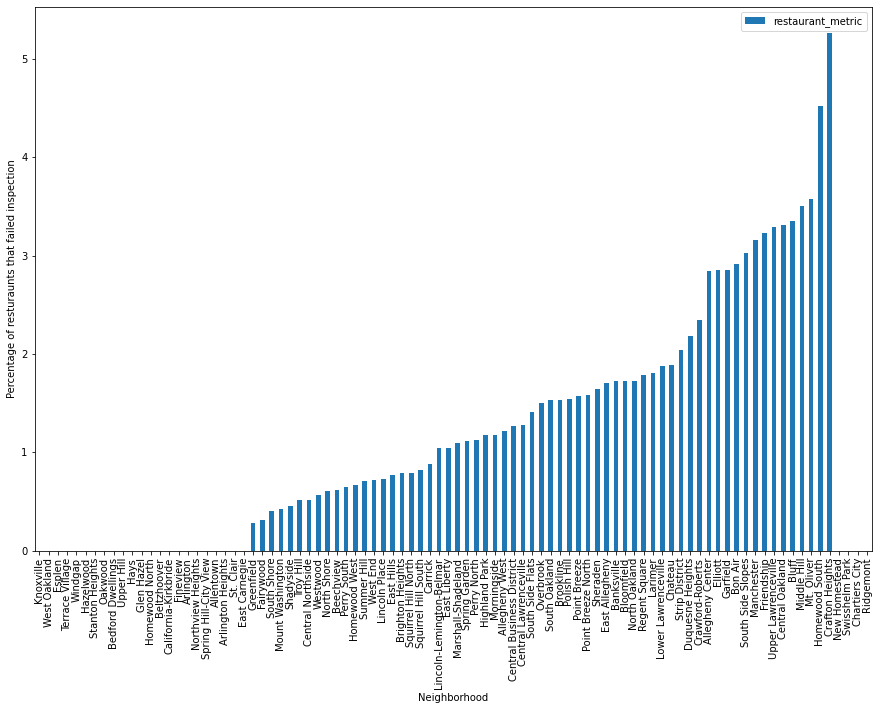

In [23]:
# Display bar graph of metric
ax = sorted_neighborhood_metrics.plot(kind = 'bar', figsize=(15,10))
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Percentage of resturaunts that failed inspection")

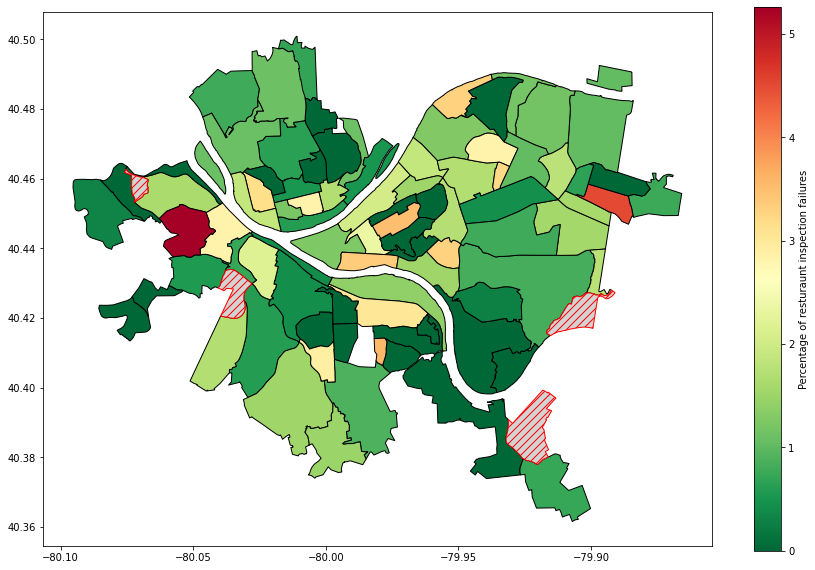

In [26]:
# Display map of metric scores for neighborhoods
neighborhoods_map = gpd.read_file("Neighborhoods/Neighborhoods_.shp")

restaurants_map = neighborhoods_map.merge(sorted_neighborhood_metrics, how = 'left', left_on = 'hood', right_on = 'neighborhood')
restaurants_map.plot(column = 'restaurant_metric', figsize = (15,10), cmap = 'RdYlGn_r',edgecolor = 'black', legend = True, 
    legend_kwds={'label': "Percentage of resturaunt inspection failures"},
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///","label": "Missing values"})


Here is the restaurant data graphed for the neighborhoods in pittsburgh. Neighborhoods with stripes are those without values in the dataset. Green neighborhoods are good (have low failure rate) while red neighborhoods are bad (high inspection failure rate)

There is a many way tie for best neighborhood by this metric, as multiple neighborhoods have no failed inspections. Hazelwood and West Oakland are two examples. The worst neighborhood is Crafton Heights with a failure rate of over 5%

# Fire Data

In [27]:
fireData = pd.read_csv("fire.csv")

Reads the fire data into a variable called fireData

In [28]:
df = fireData[['neighborhood', 'alarms']].groupby(by='neighborhood')

Creates a dataframe of the fire data, keeping only the neighborhood and alarm column and then grouping all the alarm values into which neighborhood they belong into

In [29]:
df1 = df.sum().sort_values(by='alarms')

The values of each neighborhood are all added together, and then sorted by the value in their alarms

In [30]:
df1.head()

,alarms
neighborhood,
Ridgemont,1
Mount Oliver Borough,2
New Homestead,2
Hays,3
Regent Square,3


This shows the 5 neighborhoods with the least amount of fire alarms

In [31]:
df1.tail()

,alarms
neighborhood,
Lincoln-Lemington-Belmar,120
Squirrel Hill South,124
South Side Flats,126
Central Business District,153
Carrick,162


This shows the 5 neighborhoods with the most amount of fire alarms

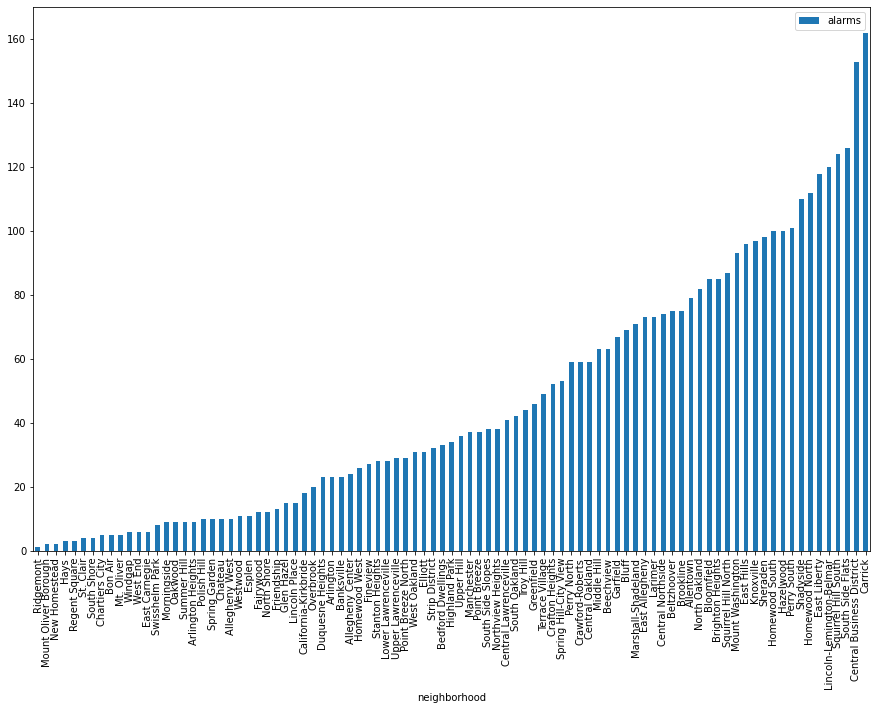

In [32]:
df1.plot(kind = 'bar', figsize=(15,10))

This is the data from all the neighborhoods plotted into an ascending bar graph

In [33]:
alarms = fireData.groupby("neighborhood").sum()['alarms']
alarms.sort_values(ascending=False)

neighborhood
Carrick                      162
Central Business District    153
South Side Flats             126
Squirrel Hill South          124
Lincoln-Lemington-Belmar     120
                            ... 
Regent Square                  3
Hays                           3
New Homestead                  2
Mount Oliver Borough           2
Ridgemont                      1
Name: alarms, Length: 91, dtype: int64

In [34]:
neighborhoods = gpd.read_file("Neighborhoods/Neighborhoods_.shp")

Creates the Pittsburgh dataset

In [35]:
alarms_map = neighborhoods.merge(alarms, how='left', left_on='hood', right_on='neighborhood')

Merges my dataset with the neighborhood dataset

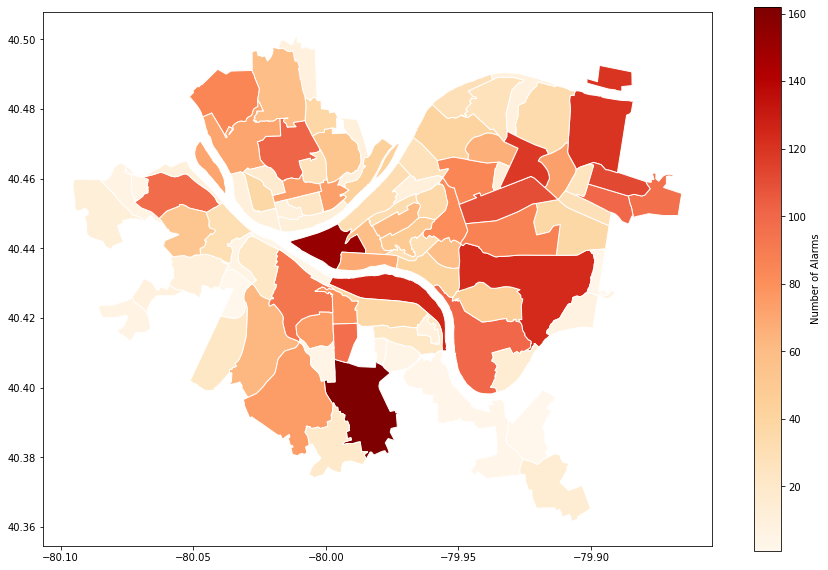

In [36]:
alarms_map.plot(column='alarms', figsize=(15,10), cmap='OrRd',edgecolor="white",legend=True,
               legend_kwds={'label': "Number of Alarms"})

Plots the data, producing a map of Pittsburgh sorted by number of fire alarms that occured in each neighborhood

# Combining the Data

Now that each dataset has been used to create a score for each neighborhood, it's time to combine those scores into one metric.

In [38]:
# Create a new dataframe to hold all the metrics from all the neighborhoods
neighborhood_metrics = pd.DataFrame()
neighborhood_metrics["neighborhood"] = neighborhood_shapes["hood"]

# Merge all metric data into the neighborhood_metrics DataFrame
neighborhood_metrics = neighborhood_metrics.merge(alarms,how= "left", on = "neighborhood")
neighborhood_metrics = neighborhood_metrics.merge(df_scores,how= "left", on = "neighborhood")
neighborhood_metrics = neighborhood_metrics.merge(restaurant_metric,how= "left", on = "neighborhood")
# Rename columns to be more obvious
neighborhood_metrics = neighborhood_metrics.rename(columns = {"score": "asbestos_metric", "alarms":"fire_metric"})

# The weight that each score gets in the final metric
asbestos_metric_scale = 2
fire_metric_scale = 1 # I chose to make this smaller because fires are an unlimited quantity
restaurant_metric_scale = 15 # The values for this are very small, between 0 and 5, so I decided to scale them up

#Function to use when calculating total metrics
metric_function = (lambda row: row["asbestos_metric"]*asbestos_metric_scale
    +row["fire_metric"]*fire_metric_scale
    +row["restaurant_metric"]*restaurant_metric_scale)

# Calculate total metrics and add to dataframe
metrics_total = neighborhood_metrics.apply(metric_function, axis = 1)
neighborhood_metrics["total_metric"] = metrics_total

neighborhood_metrics = neighborhood_metrics.sort_values("total_metric")
print(neighborhood_metrics.dropna())

                 neighborhood  fire_metric  asbestos_metric  \
18                       Hays            3              0.0   
68                  St. Clair            4              0.0   
74                    Oakwood            9              0.0   
75                  Fairywood           12              0.0   
89                   West End            6              0.0   
..                        ...          ...              ...   
67                  Arlington           23            100.0   
4                 Perry South          101             59.0   
30              Regent Square            3            100.0   
56                Polish Hill           10            100.0   
41  Central Business District          153             45.0   

    restaurant_metric  total_metric  
18           0.000000      3.000000  
68           0.000000      4.000000  
74           0.000000      9.000000  
75           0.315457     16.731861  
89           0.722892     16.843373  
..             

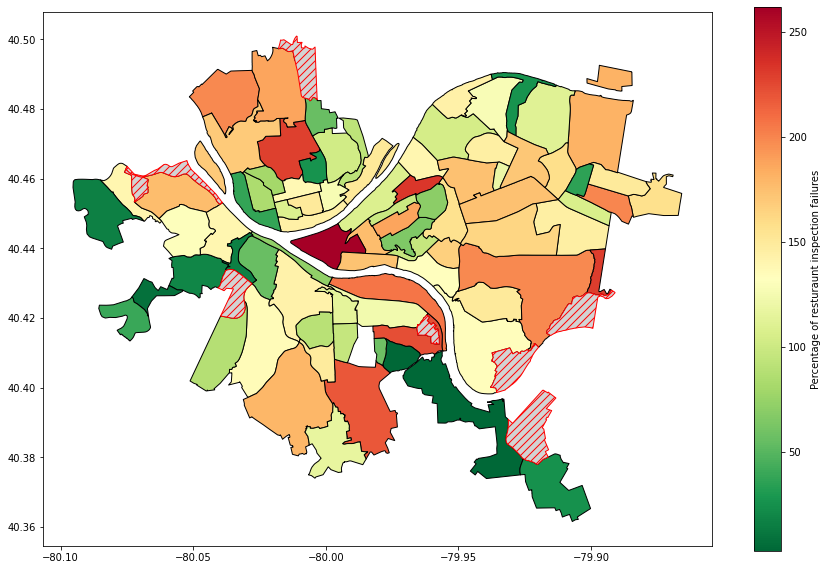

In [39]:
# Display map of metric scores for neighborhoods
neighborhoods_map = gpd.read_file("Neighborhoods/Neighborhoods_.shp")

metrics_map = neighborhoods_map.merge(neighborhood_metrics, how = 'left', left_on = 'hood', right_on = 'neighborhood')
metrics_map.plot(column = 'total_metric', figsize = (15,10), cmap = 'RdYlGn_r',edgecolor = 'black', legend = True, 
    legend_kwds={'label': "Percentage of resturaunt inspection failures"},
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///","label": "Missing values"})

In [40]:
neighborhood_metrics.head()                                # HAYS ^

,neighborhood,fire_metric,asbestos_metric,restaurant_metric,total_metric
18,Hays,3,0.0,0.000000,3.000000
68,St. Clair,4,0.0,0.000000,4.000000
74,Oakwood,9,0.0,0.000000,9.000000
75,Fairywood,12,0.0,0.315457,16.731861
89,West End,6,0.0,0.722892,16.843373


# Conclusion

After the three datasets were combined into one dataset, as you can see, Hays is the best neighborhood in Pittsburgh.
It has the lowest metric out of all the neighborhoods, with no asbestos, no restaurants inspection failures, and only
3 fire alarms. As you can see, St. Clair was a close second with one more fire alarm.